# Some ECG signal data sets
MIT-BIH cardiac arrythmia dataset to get started.
https://www.physionet.org/content/mitdb/1.0.0/

The signals were digitized @ 360 samples per second 11-bit resolution over a 10 mV range.

MIT-BIH Atrial Fibrilation data set
https://physionet.org/content/afdb/1.0.0/#files-panel

qtdb ecg database
https://physionet.org/content/qtdb/1.0.0/

Things implemented
1. signal reader
2. note on text model use case for annotations. prompt development

In [1]:
# this gives access to your whole drive and google account
# dont put anything in here that youre not using to code
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# wfdb stands for waveform database - use it for reading physiological signals
# documentation is available @ https://wfdb.readthedocs.io/en/latest/wfdb.html
!pip install wfdb

In [3]:
# do the imports
import os
import glob
import wfdb
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal as scisig
from scipy.signal import medfilt


Number of files  12
signal shape  (650000, 2)
field keys  dict_keys(['fs', 'sig_len', 'n_sig', 'base_date', 'base_time', 'units', 'sig_name', 'comments'])
signal array  [[-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.35 ]
 [-0.115 -0.355]]
fields dictionary  {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['84 F 1633 1629 x1', 'Digoxin, Quinidine', 'The episodes of paroxysmal atrial flutter/fibrillation are usually', 'followed by nodal escape beats.  There are several intervals of', 'high-frequency noise/artifact in both channels.']}


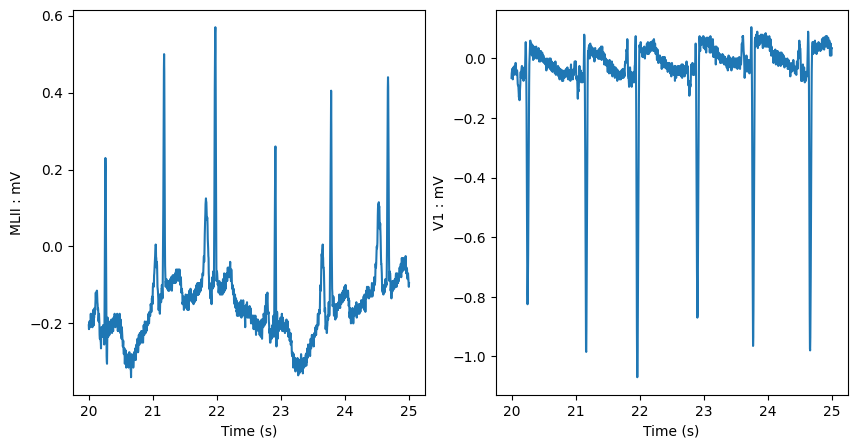

In [4]:
def Plot_signals(signals, fields, T1 = 20, t_win = 5, fs= 320):
  T2 = t_win + T1
  time_ = np.linspace(T1,T2, t_win*fs)

  fig, axes = plt.subplots(1,2, figsize=(10, 5))
  for i in range(2):
    axes[i].plot(time_, signals[T1*fs:T2*fs,i])
    axes[i].set_xlabel('Time (s)')
    # so signame here is the lead -- the view across the heart that this signal
    # gives us.
    axes[i].set_ylabel(fields['sig_name'][i] + ' : '+fields['units'][i])

def MIT_BIH_reader():
  # first pass
  hdir = '/content/drive/My Drive/PublicHeartDatasets/mit-bih-arrhythmia-database-p-wave-annotations-1.0.0/'
  # get all the file names from the data set
  hea = sorted(glob.glob(os.path.join(hdir,'*.hea')))
  hea = [hh.replace('.hea','') for hh in hea]

  # wfdb does not need the extension - it figures all that out apparently
  print('Number of files ', len(hea))

  SigNumber = -3
  # wfdb get signals
  signals, fields = wfdb.rdsamp(hea[SigNumber], )
  # print(type(signals))
  # print(type(fields))

  # signals is a numpy array, and fields is a dict
  print('signal shape ', signals.shape)
  print('field keys ', fields.keys())

  # print the array real quick
  print('signal array ', signals[0:10,:]) # signal
  print('fields dictionary ', fields) # notes about the signals

  # Note that the signals were digitized @ 360 samples per second
  # 11-bit resolution over a 10 mV range. so if you want
  fs = fields['fs'] # sampling frequency - should be 360

  # signal is already in milivolts ok.
  # plotting

  Plot_signals(signals, fields, T1 = 20, t_win = 5, fs= 320)
  return signals, fields


signals_, fields_ = MIT_BIH_reader()



---
Now we have something that can just open signal files. we probably want some denoising stuff first. Then we can start setting windows around the different peaks. -- Peak detection with old fashioned AI approahces.  

---



In [5]:
plt.close()

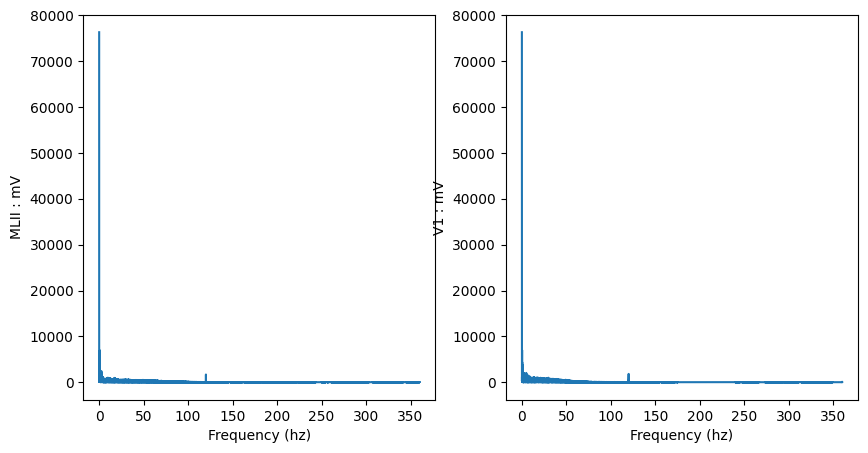

In [6]:
# signal to noise estimate right.
def MagSpectPlotter(signals_, fields_):
  signals_ = signals_ - np.mean(signals_)
  samps = int(signals_.shape[0]/2)

  spect = np.fft.fft(signals_, axis = 0,) # fast fourier transform
  mag = np.abs(spect) # magnitude at each frequency
  freqs = np.linspace(0, fields_['fs'], samps) # frequency axis

  fig, axes = plt.subplots(1,2, figsize=(10, 5))
  for i in range(2):
    axes[i].plot(freqs, mag[0:samps, i])
    axes[i].set_xlabel('Frequency (hz)')
    # # so signame here is the lead -- the view across the heart that this signal
    # # gives us.
    axes[i].set_ylabel(fields_['sig_name'][i] + ' : '+fields_['units'][i])

  plt.show()

MagSpectPlotter(signals_, fields_)

working 


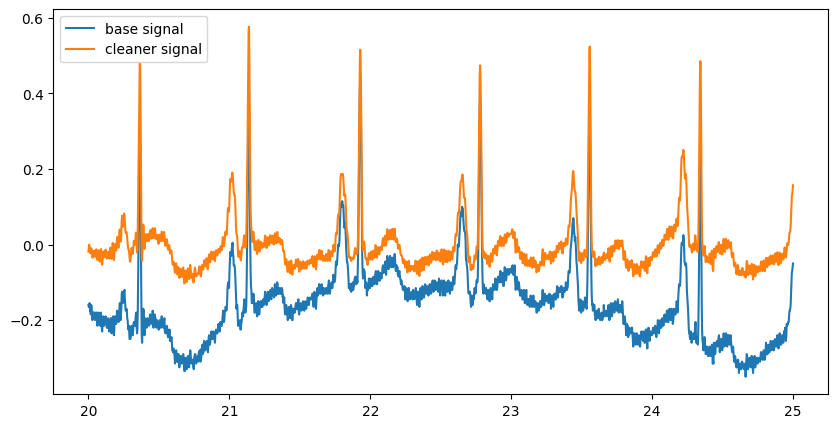

In [22]:
# program signal denoising and interval detectors here.
def NoiseReduction(signals_, fields_, T1 = 1, t_win = 5, fs= 320):
    fs = 0+fields_['fs']
    T2 = t_win + T1
    time_ = np.linspace(T1,T2, t_win*fs)
    print('working ')
    # parameters for initial band pass filtering
    cut_args={
              'smp_rate' : fs, # sampling rate
              'lp_pass' : 80, # low pass filter pass band
              'lp_stop' : 90, # low pas filter stop band
              'hp_pass' : 0.75, # high pass filter pass band
              'hp_stop' : 0.01, # high pass filter stop band
              'sb_att' : 210, # stop band attenuation
             }
    # leaving filter design components in place
    nyq_rate = cut_args['smp_rate']/2
    lbord,lwn = scisig.cheb2ord(wp = cut_args['lp_pass']/nyq_rate, ws =cut_args['lp_stop']/nyq_rate, gpass = .1, gstop = cut_args['sb_att'])
    # High pass filter stop at 0.1Hz, and pass at 1Hz
    hbord,hwn = scisig.cheb2ord(wp = cut_args['hp_pass']/nyq_rate, ws = cut_args['hp_stop']/nyq_rate, gpass = .1, gstop = cut_args['sb_att'])

    lb,la = scisig.cheby2(N = lbord, rs = cut_args['sb_att'], Wn = lwn,
                          btype = 'lowpass', output ='ba')

    hb,ha = scisig.cheby2(N = hbord, rs = cut_args['sb_att'], Wn = hwn,
                          btype = 'highpass', output ='ba')

    # right now we only get one signals
    fdat = scisig.filtfilt(lb, la, signals_[:,0])
    fdat = scisig.filtfilt(hb, ha,fdat)

    plt.figure(figsize=(10, 5))
    plt.plot(time_, signals_[fs*T1:fs*T2,0], label = 'base signal')
    plt.plot(time_, fdat[fs*T1:fs*T2], label = 'cleaner signal')
    plt.legend()
    plt.show()
# now just rewrite this to dump the cleaner signal
NoiseReduction(signals_, fields_, T1 = 20)

# median filter and call it to get rid of the little noise peaks

In [8]:
plt.close()

Ok so now we have some signal cleaning. Next step is to start identifying the beat and the QT interval, RR interval. That stuff is useful.

I want to know what all the comments are in this file

In [9]:
# want to know which files ha
def function2():
  # first pass
  hdir = '/content/drive/My Drive/PublicHeartDatasets/mit-bih-arrhythmia-database-p-wave-annotations-1.0.0/'
  # get all the file names from the data set
  hea = sorted(glob.glob(os.path.join(hdir,'*.hea')))
  hea = [hh.replace('.hea','') for hh in hea]

  # wfdb does not need the extension - it figures all that out apparently
  print('Number of files ', len(hea))

  for SigNumber in range(len(hea)):
    print(hea[SigNumber])
    # wfdb get signals
    signals, fields = wfdb.rdsamp(hea[SigNumber], )
    print(fields)
function2()

Number of files  12
/content/drive/My Drive/PublicHeartDatasets/mit-bih-arrhythmia-database-p-wave-annotations-1.0.0/100
{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}
/content/drive/My Drive/PublicHeartDatasets/mit-bih-arrhythmia-database-p-wave-annotations-1.0.0/101
{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['75 F 1011 654 x1', 'Diapres']}
/content/drive/My Drive/PublicHeartDatasets/mit-bih-arrhythmia-database-p-wave-annotations-1.0.0/103
{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V2'], 'comments': ['-1 M 742 654 x1', 'Diapres, Xyloprim']}
/content/drive/My Drive/PublicHeartDatasets/mit-bih-arrhythmia-database-p-wave-annotations-1.0.0/106
{'fs': 360, 'sig_len': 650

*'sig_name': ['MLII', 'V5']*

MLII and V5 are views across the heart for the ECG leads. Meanwhile the comments look like they say, Age Sex start stop x1/x2, medications list, comments

*'comments': ['51 M 640 654 x2', 'Digoxin, Lasix, Pronestyl', 'The lower channel has low-amplitude high-frequency noise throughout.']*


# Asking ChatGPT5 about medications that patients were on in the study
What effects would we think Pronestyl would have on the heart?
---

ChatGPT5 responds with

---

Pronestyl is the brand name for procainamide, a Class Ia antiarrhythmic drug. Its main effects on the heart come from how it alters ion flow across cardiac cells:

Mechanism of Action

* Blocks fast sodium channels → slows depolarization in cardiac myocytes, which reduces conduction velocity.

* Prolongs action potential duration by also blocking some potassium channels → lengthens the refractory period.

* These actions reduce the ability of abnormal electrical circuits to sustain arrhythmias.

Expected Cardiac Effects

* Slows conduction through the atria, ventricles, and His-Purkinje system.

* Suppresses abnormal automaticity (ectopic pacemaker activity).

* Prolongs the QT interval on ECG because of delayed repolarization.

* Treats ventricular and supraventricular arrhythmias, including atrial fibrillation, atrial flutter, and ventricular tachycardia.

Potential Adverse Effects

* Arrhythmogenic risk: QT prolongation can lead to torsades de pointes.

* Negative inotropy: can decrease contractility, especially in compromised hearts.

* Hypotension: more common with IV use due to vasodilation.

* Long-term use: can cause a lupus-like syndrome.

👉 In short: Pronestyl slows conduction, prolongs refractory periods, and can help stop arrhythmias—but it carries risks of QT prolongation and reduced pumping strength.

Would you like me to sketch out how this would look on an ECG before vs. after Pronestyl (e.g., widened QRS, prolonged QT)?


# Some other prompts to programatically ask of text models
What you want to get out of this prompt is a numercial measure you can use to supplement the Arrhythmia detector with down the line.

## A. General effects
What effects on the heart would we think *[drug]* would have on the heart in a *[age]* *[gender]* individual?

## B. A + include ECG view
What effects on the *[view]* ECG signal would we think *[drug]* would have on the heart in a *[age]* *[gender]* individual?

## C. B + include arrythmia detection
What effects on the *[view]* ECG signal would we think *[drug]* would have on the heart in a *[age]* *[gender]* individual? How would this impact an algorithm that does arrhythmia detection?

## D. C + include methodology for arrhythmia detection
What effects on the *[view]* ECG signal would we think *[drug]* would have on the heart in a *[age]* *[gender]* individual? How would this impact the R-R interval portion of an algorithm that detects arrhythmias?


## Formatted text
You could load some text like this. Like JSON format. Then ask the questions about outcome

Age: 69

Gender: M

Average RR-Interval: 0.9s

Std RR-Interval: 0.25s

Average QT-Interval: 0.2s

Std QT-Interval: 0.25s

Heart rate : 60 BPM

Medications : pronestyl

Dietary notes : high fat diet


Think about using this model for the visual question answering task.
https://huggingface.co/google/pix2struct-chartqa-base





In [10]:
# # import transformers
# from transformers import BertTokenizer, BertForMaskedLM